In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import tensorflow as tf
from glob import glob
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import models
import shutil
import random
from keras.models import load_model
from sklearn.metrics import confusion_matrix
import seaborn as sns

2023-02-17 22:26:30.443000: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Train & Test split
#### split the data to 2 separate  dirs.

### ~ RUN THIS CELL CODE ONCE! ~

In [2]:
# set random seed for reproducibility
random.seed(42)

# define paths for dataset and train/test splits
data_path = "FMD_DATASET"
train_path = "train"
test_path = "test"

# create directories for train and test data
os.makedirs(train_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

# loop over each class in the dataset
for class_name in os.listdir(data_path):
    class_path = os.path.join(data_path, class_name)

    # create directories for train and test data for this class
    train_class_path = os.path.join(train_path, class_name)
    test_class_path = os.path.join(test_path, class_name)
    os.makedirs(train_class_path, exist_ok=True)
    os.makedirs(test_class_path, exist_ok=True)

    # get list of subdirectories for this class
    subdirectories = os.listdir(class_path)

    # loop over each subdirectory in the class
    for subdirectory_name in subdirectories:
        subdirectory_path = os.path.join(class_path, subdirectory_name)

        # create directories for train and test data for this subdirectory
        train_subdirectory_path = os.path.join(train_class_path, subdirectory_name)
        test_subdirectory_path = os.path.join(test_class_path, subdirectory_name)
        os.makedirs(train_subdirectory_path, exist_ok=True)
        os.makedirs(test_subdirectory_path, exist_ok=True)

        # get list of image filenames for this subdirectory
        images = os.listdir(subdirectory_path)

        # shuffle the list of images
        random.shuffle(images)

        # split the list of images into train and test sets
        split_index = int(len(images) * 0.8)  # 80% train, 20% test
        train_images = images[:split_index]
        test_images = images[split_index:]

        # move the train and test images to their respective directories
        for image in train_images:
            src = os.path.join(subdirectory_path, image)
            dst = os.path.join(train_subdirectory_path, image)
            shutil.copyfile(src, dst)

        for image in test_images:
            src = os.path.join(subdirectory_path, image)
            dst = os.path.join(test_subdirectory_path, image)
            shutil.copyfile(src, dst)

### load data with ImageDataGenerator

First we will use ImageDataGenerator a class in the Keras library for deep learning,
which is used to preprocess image data.
The flow_from_directory method is used to generate batches of image data from a directory
containing subdirectories of images,
with each subdirectory representing a class label.
The method takes the path to the directory containing the images as an argument.

In [3]:
#Scale the pixel values of the images from a range of [0, 255] to [0, 1].
#Use 80% of the images for training and 20% for validation
datagen_train = ImageDataGenerator(
    validation_split=0.2,
    rotation_range=20,
    rescale=1./255,
    shear_range=0.2,
    fill_mode='nearest',
    zoom_range = 0.02
)
datagen_test = ImageDataGenerator(
    rotation_range=20,
    rescale=1./255,
    shear_range=0.2,
    fill_mode='nearest',
    zoom_range = 0.02
)

In [4]:
data_train = datagen_train.flow_from_directory(
    "train",
    target_size=(150, 150),
    batch_size=800,
    class_mode='categorical',
    shuffle=True,
    seed=42,
)

data_test = datagen_test.flow_from_directory(
    "test",
    target_size=(150, 150),
    class_mode='categorical',
    shuffle=False,
    seed=42
)

Found 11628 images belonging to 3 classes.
Found 2908 images belonging to 3 classes.


DATA DETAILS

In [5]:
counts_train = np.bincount(data_train.labels)
print("classes: ",data_train.class_indices,
      "\nimage shape: ", data_train.image_shape,
      "\n\ntrain: ",
      "\n  * class 'incorrect_mask' (0): ", counts_train[0],
      "\n  * class 'with_mask' (1): ", counts_train[1],
      "\n  * class 'without_mask' (2): ", counts_train[2],)

counts_test = np.bincount(data_test.labels)
print("\ntest:",
      "\n  * class 'incorrect_mask' (0): ", counts_test[0],
      "\n  * class 'with_mask' (1): ", counts_test[1],
      "\n  * class 'without_mask' (2): ", counts_test[2],)

classes:  {'incorrect_mask': 0, 'with_mask': 1, 'without_mask': 2} 
image shape:  (150, 150, 3) 

train:  
  * class 'incorrect_mask' (0):  4000 
  * class 'with_mask' (1):  3831 
  * class 'without_mask' (2):  3797

test: 
  * class 'incorrect_mask' (0):  1000 
  * class 'with_mask' (1):  958 
  * class 'without_mask' (2):  950


## CNN model architecture
In this model architecture,
we have used 3 Convolutional layers followed by 3 MaxPooling layers,
a flatten layer to convert the 3D tensor into a 1D tensor, a Dropout layer to avoid overfitting,
and finally two Dense layers to classify the images into 3 classes.

In [6]:
model_cnn = models.Sequential()
model_cnn.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model_cnn.add(layers.MaxPooling2D((2, 2)))
model_cnn.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(layers.MaxPooling2D((2, 2)))
model_cnn.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_cnn.add(layers.MaxPooling2D((2, 2)))
model_cnn.add(layers.Flatten())
model_cnn.add(layers.Dropout(0.5))
model_cnn.add(layers.Dense(64, activation='relu'))
model_cnn.add(layers.Dense(3, activation='softmax'))

2023-02-17 22:27:25.974358: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Compile the model
Here we have used 'categorical_crossentropy' as the loss function,
'adam' as the optimizer,
and 'accuracy' as the metric to evaluate the performance of the model.

In [7]:
model_cnn.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

### Train the model

In [8]:
history = model_cnn.fit(data_train, epochs=4)

Epoch 1/4
 7/15 [=============>................] - ETA: 2:16 - loss: 1.2056 - accuracy: 0.3445

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


15/15 [==============================] - 244s 15s/step - loss: 1.0754 - accuracy: 0.5037
Epoch 2/4
15/15 [==============================] - 225s 14s/step - loss: 0.4363 - accuracy: 0.8814
Epoch 3/4
15/15 [==============================] - 216s 14s/step - loss: 0.2572 - accuracy: 0.9202
Epoch 4/4
15/15 [==============================] - 220s 14s/step - loss: 0.2079 - accuracy: 0.9288


### save the model - for future predict

In [9]:
# Save the model
model_cnn.save('cnn_model.h5')

## plot the accuracy & loss during the train

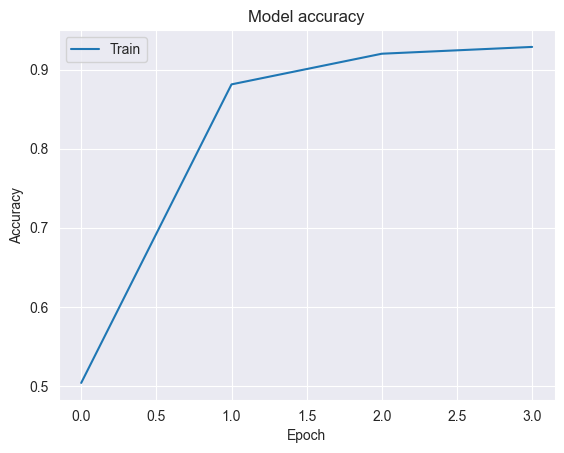

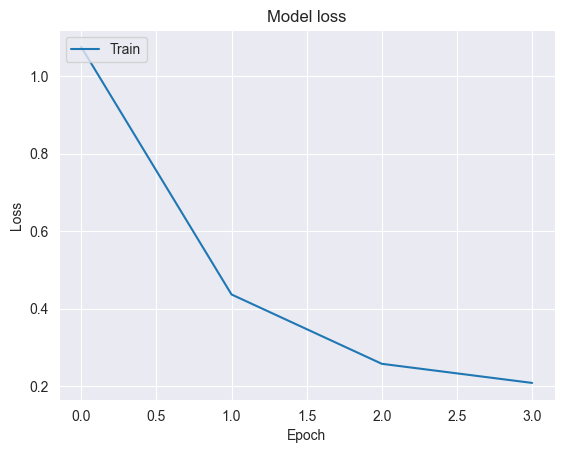

In [10]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

### Acuuracy & Loss on Train and Test

In [11]:
model_cnn_load = load_model('cnn_model.h5')

In [12]:
# Evaluate the model on the train data
train_loss, train_acc = model_cnn_load.evaluate(data_test)
print('Train Loss:', train_loss)
print('Train Accuracy:', train_acc)

# Evaluate the model on the test data
test_loss, test_acc = model_cnn_load.evaluate(data_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

91/91 [==============================] - 42s 445ms/step - loss: 0.1855 - accuracy: 0.9360
Train Loss: 0.18547217547893524
Train Accuracy: 0.9360384941101074
91/91 [==============================] - 37s 404ms/step - loss: 0.1883 - accuracy: 0.9347
Test Loss: 0.18825024366378784
Test Accuracy: 0.9346629977226257


In [13]:
# Get the number of samples in the test set
num_samples = len(data_test.filenames)

# Generate predictions for the entire test set
predictions = model_cnn_load.predict(data_test, steps=num_samples // data_test.batch_size)

# Convert predictions from probabilities to class labels
y_pred = predictions.argmax(1)

# Get the true labels for the test set
y_true = data_test.labels[:2880]

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)
print(cm)

90/90 [==============================] - 37s 412ms/step
[[971  20   9]
 [  9 879  70]
 [  9  69 844]]


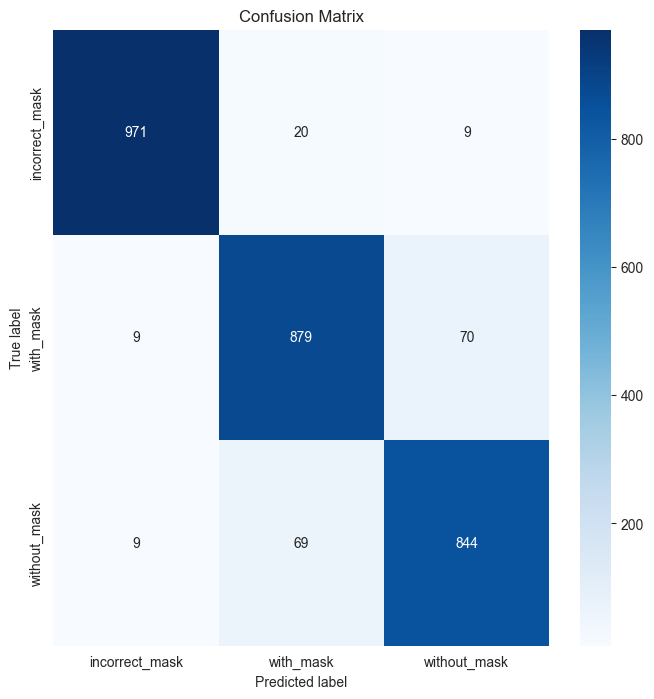

In [14]:
# Define the class labels
class_labels = list(data_test.class_indices.keys())

# Plot the confusion matrix as a heatmap
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues', ax=ax)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()


## results

   * train: 93.1%
   * test: 93.0%

-->  the model learned the data well, and there is no overfitting!

in addition, the confusion matrix has good results too



## Machine Learning
   Now we are going to use the CNN model we trained already for build encoder model that take the input from the
   CNN input layer and output the activations of its second-to-last layer, which are the extracted features.
   This allows us to use the pre-trained CNN model as a feature extractor, without having to retrain the entire model.


  We will use the encoder we created for the train and test data that represents the images as vectors,
  the encoder is actually the result of reducing the dimensions of the images

In [46]:
from keras.models import Model
# Extract features using the trained CNN model
encoder = Model(inputs=model_cnn.input, outputs=model_cnn.layers[-2].output)

train_features = []
train_labels = []
for i in range(len(data_train)):
    batch = data_train[i]
    features = encoder.predict(batch[0])
    train_features.append(features)
    train_labels.append(batch[1])
train_features = np.concatenate(train_features, axis=0)
train_labels = np.concatenate(train_labels, axis=0)

test_features = []
test_labels = []
for i in range(len(data_test)):
    batch = data_test[i]
    features = encoder.predict(batch[0])
    test_features.append(features)
    test_labels.append(batch[1])
test_features = np.concatenate(test_features, axis=0)
test_labels = np.concatenate(test_labels, axis=0)


25/25 [==============================] - 3s 119ms/step


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


1/1 [==============================] - 0s 113ms/step


In [47]:
train_labels = np.argmax(train_labels, axis=1)
test_labels = np.argmax(test_labels, axis=1)

In [55]:
print("train shape: ", train_features.shape ,"\n",
      "train labels shape: ", train_labels.shape, "\n",
      "test shape: ", test_features.shape, "\n",
      "test labels shape: " ,test_labels.shape)

train shape:  (11628, 64) 
 train labels shape:  (11628,) 
 test shape:  (2908, 64) 
 test labels shape:  (2908,)


In [60]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def printAcc(model):
    model.fit(train_features, train_labels)
    train_acc = model.score(train_features, train_labels)
    test_acc = model.score(test_features, test_labels)

    print("Train accuracy of ",model," model: " ,train_acc)
    print("Test accuracy of ",model," model: ", test_acc)

    # Calculate the confusion matrix for the test set
    y_pred = model.predict(test_features)
    cm = confusion_matrix(test_labels, y_pred)

    # Plot the confusion matrix using seaborn's heatmap
    sns.heatmap(cm, annot=True,fmt='.0f', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion matrix for '+str(model)+' model')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train accuracy of  LogisticRegression(multi_class='multinomial')  model:  0.9380804953560371
Test accuracy of  LogisticRegression(multi_class='multinomial')  model:  0.9398211829436038


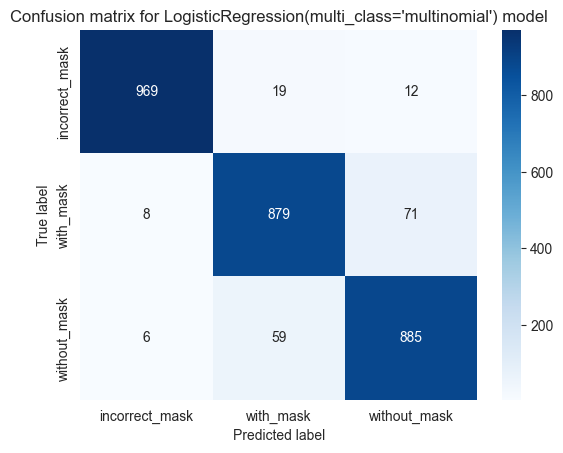

In [61]:
from sklearn.linear_model import LogisticRegression

# Train a machine learning model on the extracted features
lOGclf = LogisticRegression(solver='lbfgs', multi_class='multinomial')
printAcc(lOGclf)


Train accuracy of  RandomForestClassifier()  model:  1.0
Test accuracy of  RandomForestClassifier()  model:  0.9456671251719395


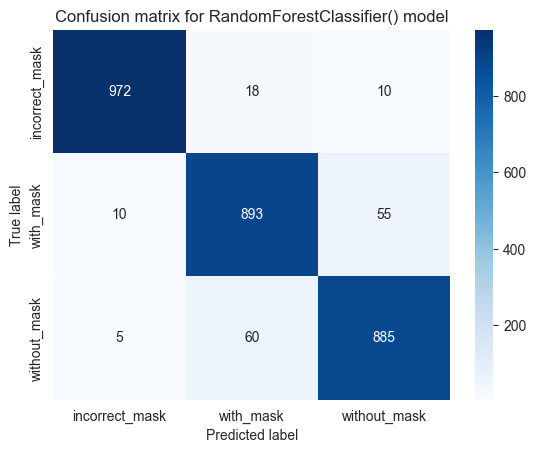

In [62]:
from sklearn.ensemble import RandomForestClassifier
RANDclf = RandomForestClassifier()
printAcc(RANDclf)

Train accuracy of  KNeighborsClassifier()  model:  0.9509803921568627
Test accuracy of  KNeighborsClassifier()  model:  0.937414030261348


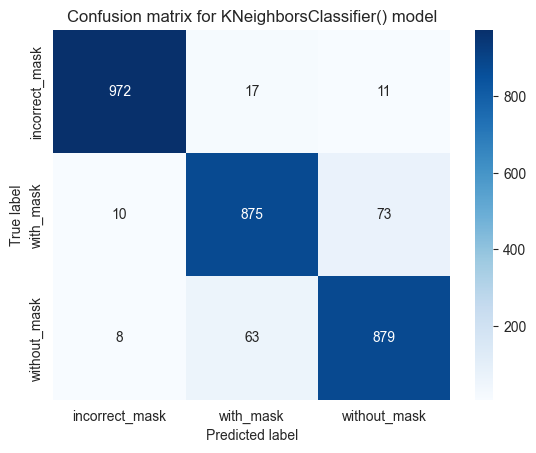

In [63]:
from sklearn.neighbors import KNeighborsClassifier

# Train a KNN model on the extracted features
knn = KNeighborsClassifier(n_neighbors=5)
printAcc(knn)

Train accuracy of  SVC(C=1, kernel='linear')  model:  0.9388544891640866
Test accuracy of  SVC(C=1, kernel='linear')  model:  0.9425722145804677


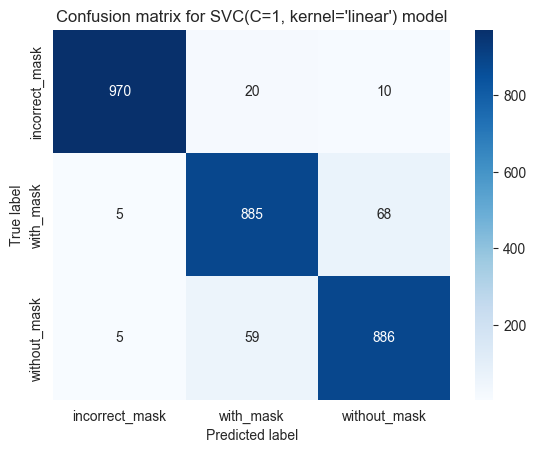

In [64]:
from sklearn import svm

# Train an SVM model on the extracted features
svm_model = svm.SVC(kernel='linear', C=1, gamma='scale')
printAcc(svm_model)

Train accuracy of  DecisionTreeClassifier()  model:  1.0
Test accuracy of  DecisionTreeClassifier()  model:  0.920907840440165


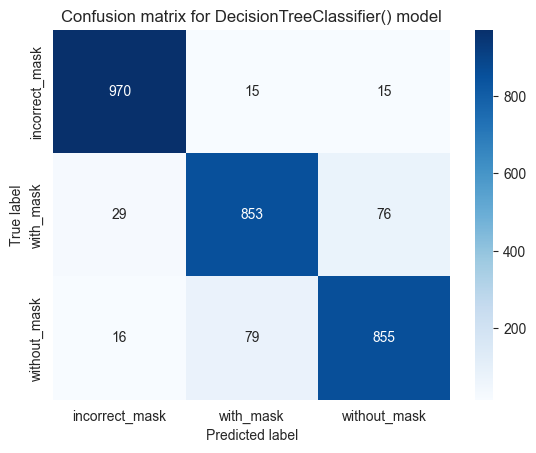

In [65]:
from sklearn.tree import DecisionTreeClassifier

# Train a decision tree model on the extracted features
tree = DecisionTreeClassifier()
printAcc(tree)
